In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

houses_colors = {'Gryffindor': '#7F0909', 'Slytherin': '#0D6217', 'Hufflepuff': '#EEE117', 'Ravenclaw': '#000A90'}

In [2]:
def warn_diff(feature, val_type, standard_val, local_val):
    print("DIFF FOR: [%s] [%s] [%f] [%f]" % (feature, val_type, standard_val, local_val))

In [3]:
def trim_dataset(dataset):
    # Getting rid of the useless Index column
    if ("Index" in dataset.columns):
        dataset.drop("Index", inplace=True, axis=1)

    # Drop empty columns
    dataset.dropna(axis=1, how='all', inplace=True)

    # Retrieve only columns with numeric values
    dataset = dataset._get_numeric_data()

    # Drop nan lines from columns
    dataset.dropna(inplace=True)
    
    return dataset

In [4]:
def my_count(values):
    count = 0.0
    for value in values:
        count += 1
    return count

In [5]:
def my_sum(values):
    s = 0
    for value in values:
        s += value
    return s

In [6]:
def my_mean(values, count=None):
    if count is None:
        count = my_count(values)
    if count > 0:
        return (my_sum(values) / count)
    else:
        print("Error in my_mean: counted [%f] elements in values" % (count))
        return None

In [7]:
# We set count default value as None so that if feature has already been counted, we can just pass it as a parameter instead of calculating again in the 
# function, but the function still keeps the ability to count the feature
def my_std(values, mean, ddof=0, count=None):
    total = 0.0
    if count is None:
        count = my_count(values)
    if count > 0:
        for value in values:
            total += abs(value - mean)**2
        std = np.sqrt(total / (count - ddof))
        return std
    else:
        print("Error in my_std: counted [%f] elements in values" % (count))
        return None

In [8]:
def my_min(values):
    m = values[0]
    for value in values:
        if value < m:
            m = value
    return m

In [9]:
def my_max(values):
    m = values[0]
    for value in values:
        if value > m:
            m = value
    return m

In [10]:
# Pure-Python implementation of percentile function: https://stackoverflow.com/a/2753343
def my_quantile(values, quantile, count=None):
    duplicate = values.copy()
    duplicate.sort_values(inplace=True)
    if count is None:
        count = my_count(values)
    if count > 0:
        k = (count -1) * quantile
        f = math.floor(k)
        c = math.ceil(k)
        if f == c:
            return (duplicate.iloc[int(k)])
        d0 = duplicate.iloc[int(f)] * (c-k)
        d1 = duplicate.iloc[int(c)] * (k-f)
        return d0+d1
    else:
        print("Error in my_quantile: counted [%f] elements in values" % (count))

In [11]:
def read_file(filename):
    try:
        dataset = pd.read_csv(filename)
    except FileNotFoundError:
        print("File not found, exiting program")
    except OSError:
        print("OSError raised reading the file, exiting program")
    except pd.errors.ParserError:
        print("Invalid file, exiting program")
    else:
        return dataset
    exit(1)

In [12]:
def pair_plot(dataset, trimmed_dataset, use_houses_colors=False):
    graph = sns.pairplot(
        dataset,
        hue="Hogwarts House",
        vars=trimmed_dataset,
        plot_kws={'alpha':0.2},
        diag_kind='hist',
        diag_kws={'alpha':0.6},
        palette=houses_colors
    )
    plt.show()

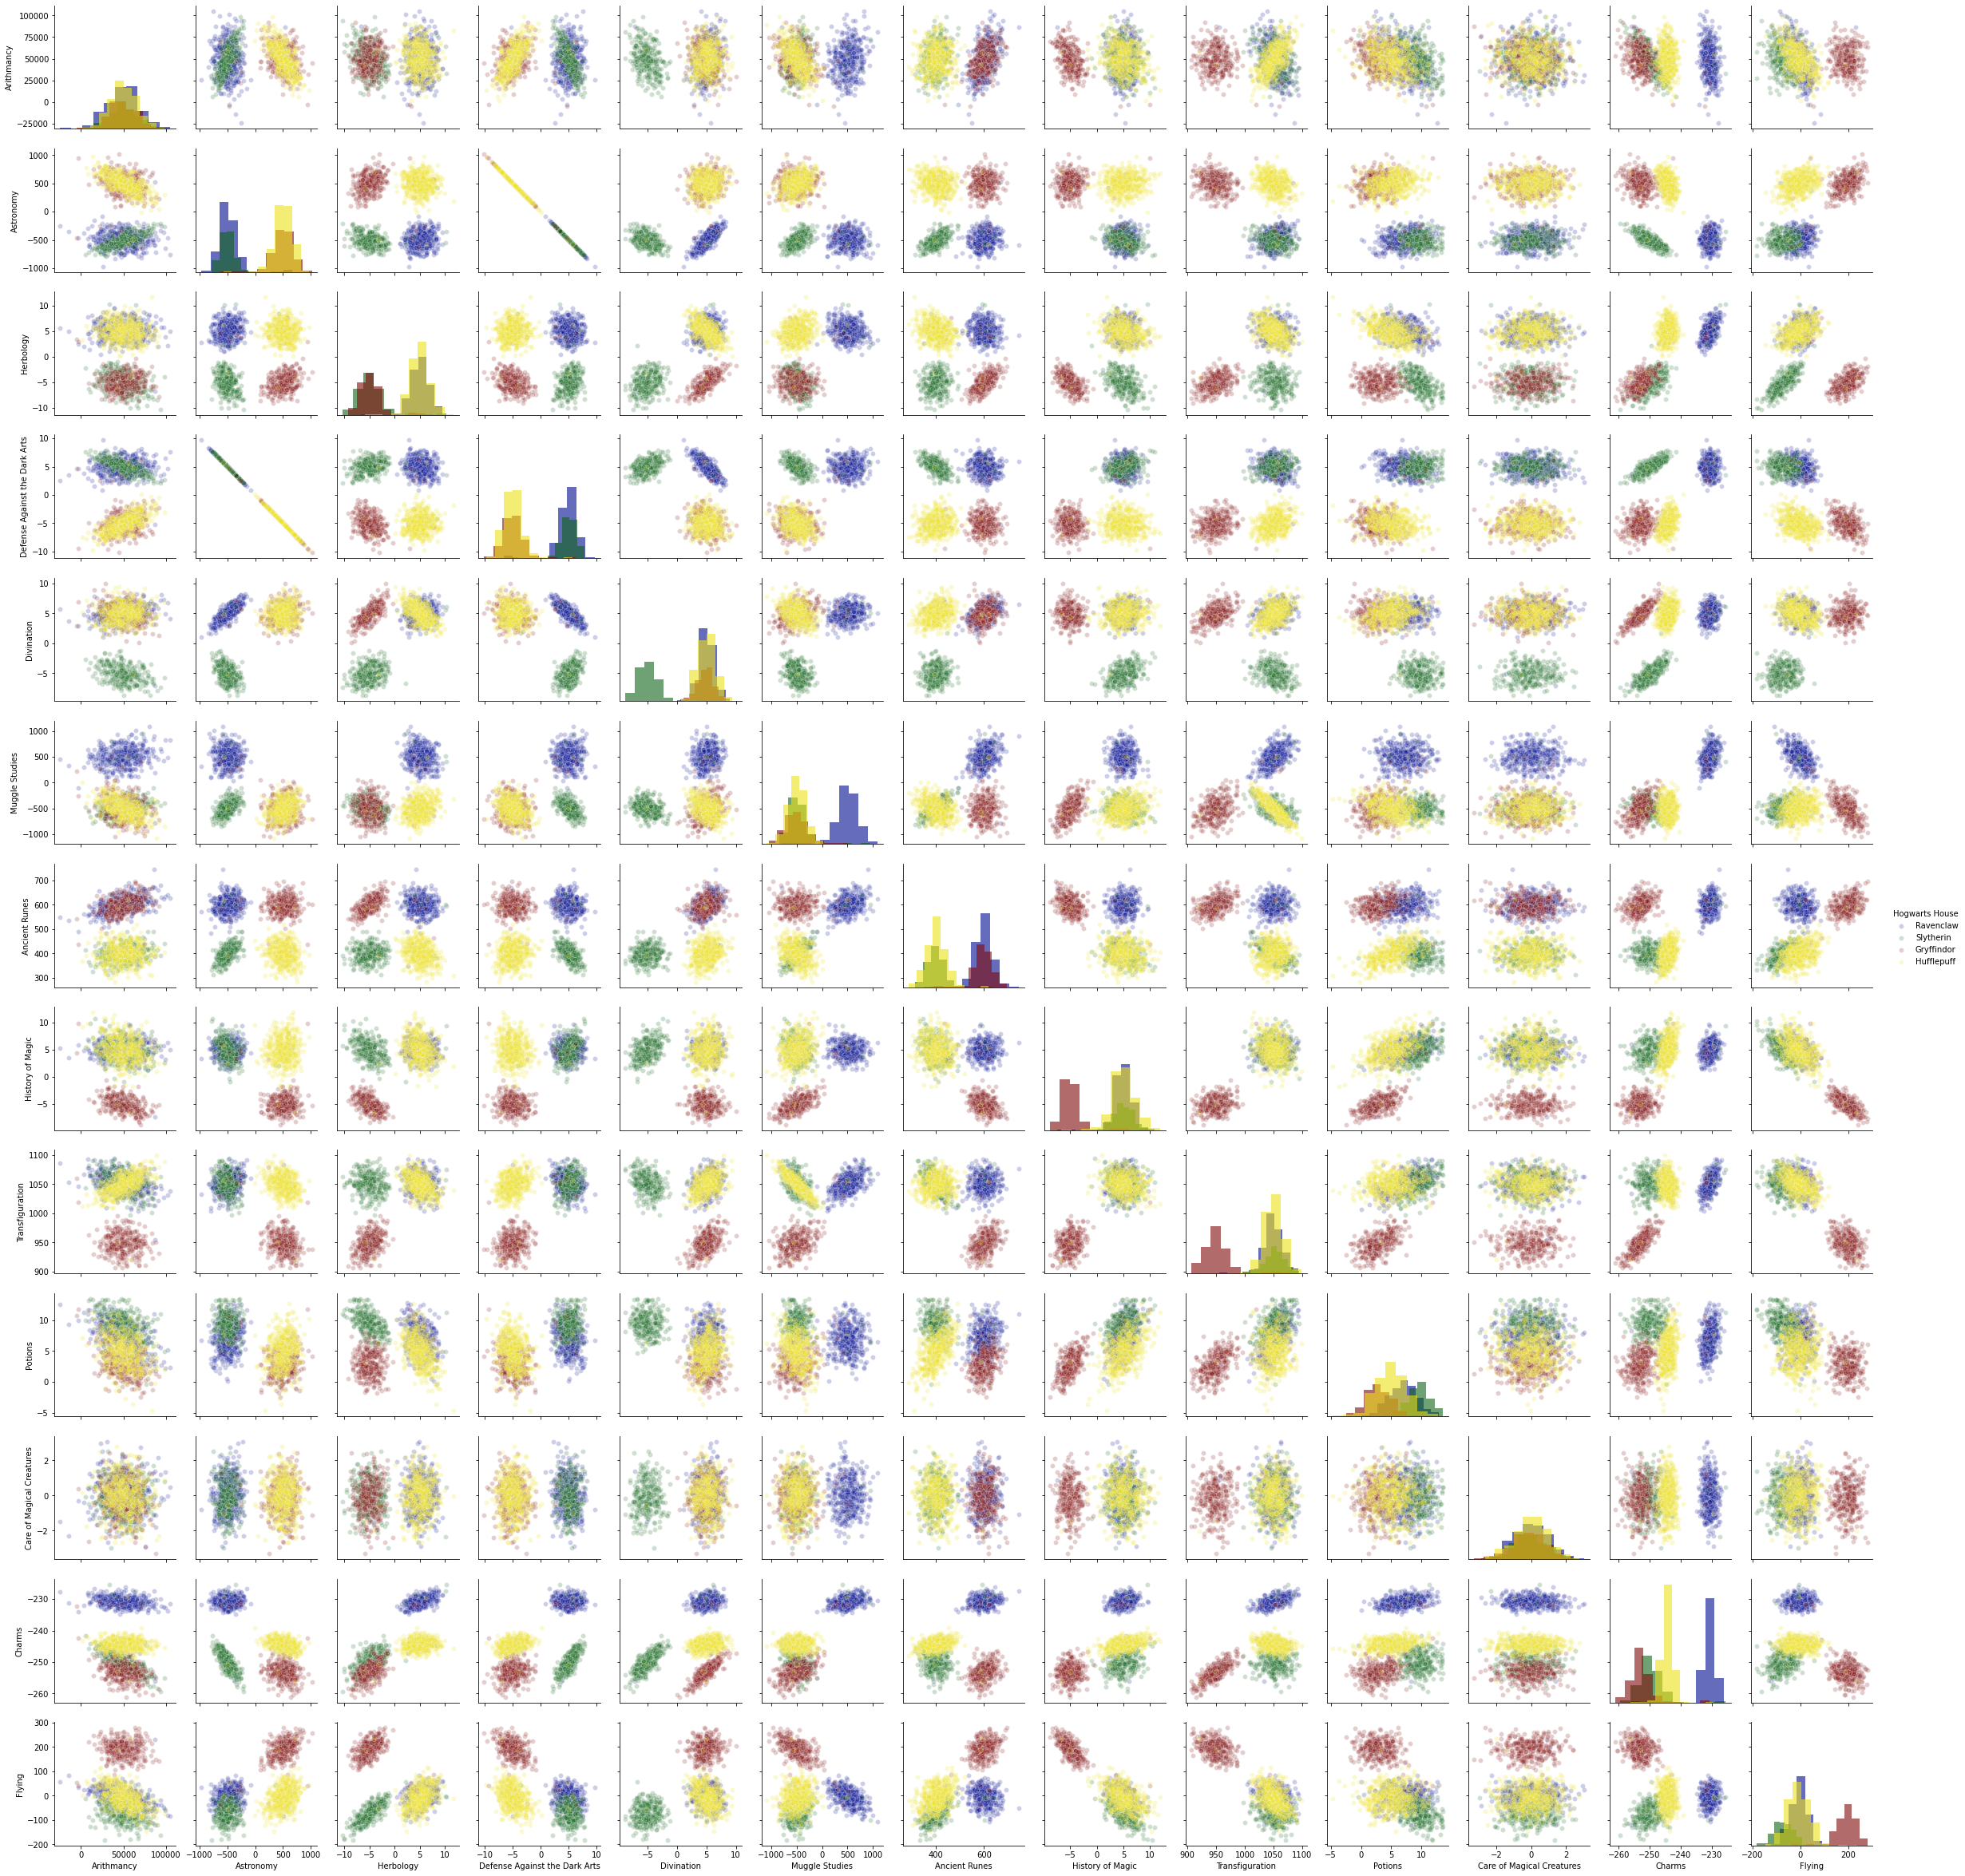

In [13]:
# "Delta Degrees of Freedom" - Not exactly sure of what it does with such datasets
ddof = 0
# Read CSV file with pandas
dataset_orig = read_file("datasets/dataset_train.csv")
# Trim the dataset to avoid nans and keep only the numeric values that will be used in calculations
dataset = trim_dataset(dataset_orig.copy())
# Plotting the dataset
pair_plot(dataset_orig, dataset, use_houses_colors=True)

In [14]:
# Values calculated with our functions go to describe dict
describe = {}
# Values calculated with system/numpy functions go to control_values dict
# It will allow us to check if our functions return correct values
control_values = {}
for feature in dataset:
    describe[feature] = {}
    control_values[feature] = {}

    control_values[feature]["count"] = dataset[feature].count()
    describe[feature]["count"] = my_count(dataset[feature])

    control_values[feature]["mean"] = dataset[feature].mean()
    describe[feature]["mean"] = my_mean(dataset[feature], count=describe[feature]["count"])

    control_values[feature]["std"] = dataset[feature].std(ddof=ddof)
    describe[feature]["std"] = my_std(dataset[feature], describe[feature]["mean"], ddof=ddof, count=describe[feature]["count"])

    control_values[feature]["min"] = dataset[feature].min()
    describe[feature]["min"] = my_min(dataset[feature])

    control_values[feature]["25%"] = dataset[feature].quantile(.25, interpolation='linear')     
    describe[feature]["25%"] = my_quantile(dataset[feature], .25, count=describe[feature]["count"])

    control_values[feature]["50%"] = dataset[feature].quantile(.5, interpolation='linear')     
    describe[feature]["50%"] = my_quantile(dataset[feature], .5, count=describe[feature]["count"])

    # We compare numpy median with our 50% quantile, since these are supposed to be the same values
    control_values[feature]["median"] = dataset[feature].median()
    describe[feature]["median"] = describe[feature]["50%"]

    control_values[feature]["75%"] = dataset[feature].quantile(.75, interpolation='linear')     
    describe[feature]["75%"] = my_quantile(dataset[feature], .75, count=describe[feature]["count"])

    control_values[feature]["max"] = dataset[feature].max()
    describe[feature]["max"] = my_max(dataset[feature])

    # For each significative difference between results from our functions and results from system/numpy functions, we output a warning
    for value in control_values[feature].keys():
        if not np.isclose(describe[feature][value], control_values[feature][value]):
            warn_diff(feature, value, describe[feature][value], control_values[feature][value])

In [15]:
for feature in describe.keys():
    print("Feature name: [%s]" % (feature))
    for value in describe[feature].keys():
        print("\t%s: [%0.6f]" % (value, describe[feature][value]))

Feature name: [Arithmancy]
	count: [1251.000000]
	mean: [49453.109512]
	std: [16694.876442]
	min: [-24370.000000]
	25%: [38180.000000]
	50%: [48793.000000]
	median: [48793.000000]
	75%: [60794.500000]
	max: [104956.000000]
Feature name: [Astronomy]
	count: [1251.000000]
	mean: [46.476449]
	std: [520.737840]
	min: [-966.740546]
	25%: [-485.323010]
	50%: [272.071636]
	median: [272.071636]
	75%: [528.346042]
	max: [1016.211940]
Feature name: [Herbology]
	count: [1251.000000]
	mean: [1.189457]
	std: [5.221049]
	min: [-10.295663]
	25%: [-4.252260]
	50%: [3.526427]
	median: [3.526427]
	75%: [5.463740]
	max: [10.296759]
Feature name: [Defense Against the Dark Arts]
	count: [1251.000000]
	mean: [-0.464764]
	std: [5.207378]
	min: [-10.162119]
	25%: [-5.283460]
	50%: [-2.720716]
	median: [-2.720716]
	75%: [4.853230]
	max: [9.667405]
Feature name: [Divination]
	count: [1251.000000]
	mean: [3.213831]
	std: [4.109348]
	min: [-8.727000]
	25%: [3.120500]
	50%: [4.621000]
	median: [4.621000]
	75%: [5.